In [3]:
# Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import os
from skimage.feature import hog
from skimage import color, exposure
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.cross_validation import train_test_split

%matplotlib inline


/home/joel/.conda/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
# images are divided up into vehicles and non-vehicles

imgsNon =  glob.glob('non-vehicles/*/*.png')
imgsCars =  glob.glob('vehicles/*/*.png')

cars = []
notcars = []

for impath in imgsNon:
    notcars.append(mpimg.imread(impath))    

for impath in imgsCars:
    cars.append(mpimg.imread(car))
    
sampleSize = 500
cars = cars[0:sampleSize]
notcars = notcars[0:sampleSize]
        
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = car_list[0]
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print(data_info)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = cars[car_ind]
notcar_image = notcars[notcar_ind]


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')




NameError: name 'car' is not defined

In [ ]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

    """
    Function accepts params and returns HOG features (optionally flattened) and an optional matrix for 
    visualization. Features will always be the first return (flattened if feature_vector= True).
    A visualization matrix will be the second return if visualize = True.
    """

# Define a function to compute histogram of gradients (hog) features  
def get_hog(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                     hist_bins=32, hist_range=(0, 256), orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = []
        # Read in each one by one
#         image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                featureImg = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                # image = img * 255
                # image = img.astype(np.uint8)
                featureImg = cv2.cvtColor(image, cv2.COLOR_RGB2Luv)
            elif cspace == 'HLS':
                featureImg = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                featureImg = cv2.cvtColor(image, cv2.COLOR_RGBYUV)
        else: featureImg = np.copy(image)
        # Apply bin_spatial() to get spatial color features
        if spatial_feat == True:
            spatial_features = bin_spatial(featureImg, size=spatial_size)
            file_features.append(spatial_features)

            # Append features to list
        # Compute histogram features if flag is set
        if hist_feat == True:
            hist_features = color_hist(featureImg, nbins=hist_bins, bins_range=hist_range)
            file_features.append(hist_features)
            # Append features to list
        # Compute HOG features if flag is set
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(featureImg.shape[2]):
                    hog_features.extend(get_hog(featureImg[:,:,channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
            else:
                hog_features = get_hog(featureImg[:,:,hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append features to list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
        
        print("spatial: ", len(spatial_features))
        print("histogram: ", len(hist_features))
        print("hog: ", len(hog_features))

    # Return list of feature vectors
    return features


In [ ]:
carImg = cars[5]
_, carDst = get_hog(carImg[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
noncarImg = notcars[5]
_, noncarDst = get_hog(noncarImg[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(carImg)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(carDst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(noncarImg)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncarDst, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)
print('...')

In [5]:
spatial = 32
histbin = 32
histrange = (0, 256)
colorspace = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 16
pix_per_cell = 15
cell_per_block = 4
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t=time.time()

carFtrs = extract_features(cars, cspace=colorspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range= histrange, orient = orient, pix_per_cell = pix_per_cell, 
                        cell_per_block = cell_per_block, hog_channel=hog_channel, spatial_feat=True, 
                        hist_feat=True, hog_feat=True)
notcarFtrs = extract_features(notcars, cspace=colorspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range= histrange, orient = orient, pix_per_cell = pix_per_cell,
                        cell_per_block = cell_per_block,hog_channel=hog_channel, spatial_feat=True, 
                        hist_feat=True, hog_feat=True)


print('Car features list length: ', len(carFtrs))
print('Not car features list length: ', len(notcarFtrs))


t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# # Define array stack of feature vectors
X = np.vstack((carFtrs, notcarFtrs)).astype(np.float64)

# # Define the labels vectors
y = np.hstack((np.ones(len(carFtrs)), np.zeros(len(notcarFtrs))))

# # Split up data into randomized training and test snippets
randState = np.random.randint(0, 100)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, random_state = randState)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(Xtrain[0]))



/home/joel/.conda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768


spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768


spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768


spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768


spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768


spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768


spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768


spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768


spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768


spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768


spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768


spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768


spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768


spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768


spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768


spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768


spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768


spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768


spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768


spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768


spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768


spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768


spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768


spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768


spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768


spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768


spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768


spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768


spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768


spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768


spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768


spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768


spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768


spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768


spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768


spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768


spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [85]:
# Fit a per-column scaler only on the training data
Xscaler = StandardScaler().fit(Xtrain)
# Apply the scaler to Xtrain and Xtest
Xtrain = Xscaler.transform(Xtrain)
Xtest = Xscaler.transform(Xtest)

# print('Using spatial binning of:', spatial, 'and', histbin, 'histogram bins')
# print('Feature vector length:', len(Xtrain[0]))

# Use a liner SVC
svc = LinearSVC()

# Check the training time for the SVC
t = time.time()
svc.fit(Xtrain, ytrain)

t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train SVC...')

# Check the score  of the SVC
print('Test Accuracy of SVC = ', round(svc.score(Xtest, ytest), 4))
# Check the prediction time for a single sample
t = time.time()
nPredict = 10
print('My SVC predicts: ', svc.predict(Xtest[0:nPredict]))
print('For these', nPredict, 'labels: ', ytest[0:nPredict])

t2 = time.time()
print(round(t2 - t, 5), 'Seconds to predict ', nPredict, ' labels with SVC')


0.11 Seconds to train SVC...
Test Accuracy of SVC =  1.0
My SVC predicts:  [ 1.  0.  1.  0.  1.  1.  1.  1.  0.  0.]
For these 10 labels:  [ 1.  0.  1.  0.  1.  1.  1.  1.  0.  0.]
0.00215 Seconds to predict  10  labels with SVC


In [102]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
        
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)

    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
        else:
            hog_features = get_hog(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
    #8) Append features to list
    print("spatial: ", len(spatial_features))
    print("histogram: ", len(hist_features))
    print("hog: ", len(hog_features))
    img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64),interpolation=cv2.INTER_AREA)      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy   
    

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
#     print("img.shape[0]: ", img.shape[0])
#     print("img.shape[1]: ", img.shape[1])

    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
#     print("xspan: ", xspan)
#     print("yspan: ", yspan)

    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
#     print("nx_pix_per_step: ", nx_pix_per_step)
#     print("ny_pix_per_step: ", ny_pix_per_step)

    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    
#     print("nx_buffer: ", nx_buffer)
#     print("ny_buffer: ", ny_buffer)
    
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    
#     print("nx_windows: ", nx_windows)
#     print("ny_windows: ", nx_windows)

    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))

    # Return the list of windows
    return window_list


/home/joel/.conda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768
spatial:  3072
histogram:  96
hog:  768


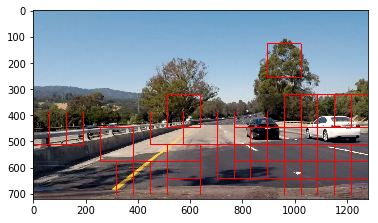

In [103]:
spatial = 32
spatialSize = (spatial, spatial)
histBins = 32
histRange = (0, 256)
colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 16
pix_per_cell = 15
cell_per_block = 4
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_feat = True
hist_feat = True
hog_feat = True


image = mpimg.imread('test_images/test4.jpg')
draw_image = np.copy(image)


# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

plt.imshow(image)
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, Xscaler, color_space=colorspace, 
                        spatial_size=spatialSize, hist_bins=histBins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 

print(len(windows))
                       
window_img = draw_boxes(draw_image, hot_windows, color=(255, 0, 0), thick=2)                    
plt.imshow(window_img)
plt.show()